# Предобученный UNet для семантической сегментации

В этом ноутбуке мы реализуем обучение предобученной модели UNet для семантической сегментации на датасете CamVid. Используем PyTorch Lightning для обучения модели.


## Установка зависимостей

Устанавливаем библиотеку segmentation_models_pytorch для работы с предобученными моделями сегментации.


In [17]:
%pip install -q segmentation-models-pytorch albumentations

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\seog\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## Импорты и настройка

Импортируем необходимые библиотеки для работы с предобученным UNet, PyTorch Lightning и обработки данных.


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np
from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

torch.manual_seed(42)
np.random.seed(42)
pl.seed_everything(42)


Seed set to 42


42

In [19]:
# CamVid RGB класс mapping
CAMVID_LABELS = {
    0: [128, 128, 128],   # Sky
    1: [128, 0, 0],       # Building
    2: [192, 192, 128],   # Column-Pole
    3: [128, 64, 128],    # Road
    4: [0, 0, 192],       # Sidewalk
    5: [128, 128, 0],     # Tree
    6: [192, 128, 128],   # Sign-Symbol
    7: [64, 64, 128],     # Fence
    8: [64, 0, 128],      # Car
    9: [64, 64, 0],       # Pedestrian
    10: [0, 128, 192],    # Bicyclist
    11: [0, 0, 0]         # Void
}
RGB_TO_CLASS = {tuple(v): k for k, v in CAMVID_LABELS.items()}
def rgb_to_class_index(mask_rgb):
    """Convert RGB mask to class indices"""
    h, w, c = mask_rgb.shape
    mask_class = np.zeros((h, w), dtype=np.int64)
    
    for rgb, class_idx in RGB_TO_CLASS.items():
        match = (mask_rgb == rgb).all(axis=2)
        mask_class[match] = class_idx
    
    return mask_class

## Аугментации данных

Определяем аугментации для обучения и валидации с использованием библиотеки albumentations.


In [20]:
def get_train_augmentation(img_size=(512, 512)):
    return A.Compose([
        A.Resize(img_size[0], img_size[1]),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.ElasticTransform(p=0.3, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.CoarseDropout(max_holes=8, max_height=16, max_width=16, min_holes=1, fill_value=0, p=0.3),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

def get_val_augmentation(img_size=(512, 512)):
    return A.Compose([
        A.Resize(img_size[0], img_size[1]),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

## Датасет для сегментации

Используем CamVid для семантической сегментации. Датасет содержит 12 классов дорожных сцен.


In [21]:
class CamVidDataset(Dataset):
    def __init__(self, data_dir, split='train', img_size=(512, 512), transform=None):
        self.data_dir = data_dir
        self.img_size = img_size
        self.transform = transform
        
        txt_file = os.path.join(data_dir, split + '.txt')
        self.samples = []  # ЭТА СТРОКА КЛЮЧЕВАЯ - создает атрибут samples
        
        with open(txt_file, 'r') as f:
            for line in f:
                line = line.strip()
                if line:
                    parts = line.split()
                    if len(parts) >= 2:
                        img_path_abs = parts[0]
                        mask_path_abs = parts[1]
                        
                        img_filename = os.path.basename(img_path_abs)
                        mask_filename = os.path.basename(mask_path_abs)
                        
                        img_path = os.path.join(data_dir, split, img_filename)
                        mask_path = os.path.join(data_dir, split + 'annot', mask_filename)
                        
                        if os.path.exists(img_path) and os.path.exists(mask_path):
                            self.samples.append((img_path, mask_path))
        
        print("Loaded {} samples from {} split".format(len(self.samples), split))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]
        
        # Load image as RGB
        image = np.array(Image.open(img_path).convert('RGB'))
        
        # Load mask as RGB and convert to class indices (КЛЮЧЕВОЕ ИСПРАВЛЕНИЕ!)
        mask_rgb = np.array(Image.open(mask_path).convert('RGB'))
        mask = rgb_to_class_index(mask_rgb)
        
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
            
            if isinstance(image, np.ndarray):
                image = torch.from_numpy(image).permute(2, 0, 1).float()
            if isinstance(mask, np.ndarray):
                mask = torch.from_numpy(mask).long()
        else:
            image = Image.fromarray(image).resize(self.img_size, Image.BILINEAR)
            image = np.array(image).astype(np.float32) / 255.0
            image = torch.from_numpy(image).permute(2, 0, 1)
            
            mask = Image.fromarray(mask.astype(np.uint8)).resize(self.img_size, Image.NEAREST)
            mask = np.array(mask).astype(np.int64)
            mask = torch.from_numpy(mask)
        
        return image, mask

## Архитектура предобученного UNet

Используем предобученную модель UNet из библиотеки segmentation_models_pytorch. UNet с предобученным энкодером ResNet34 обеспечивает хорошее качество сегментации.


In [22]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import FocalLoss

encoder_name = "efficientnet-b3"
encoder_weights = "imagenet"

model = smp.Unet(
    encoder_name=encoder_name,
    encoder_weights=encoder_weights,
    in_channels=3,
    classes=12,
)

print(f"Model: UNet with {encoder_name} encoder")
print(f"Encoder weights: {encoder_weights}")
print(f"Number of classes: 12")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")

Model: UNet with efficientnet-b3 encoder
Encoder weights: imagenet
Number of classes: 12
Number of parameters: 13,160,628


## Lightning модуль для обучения

Создаём PyTorch Lightning модуль для обучения модели UNet.


In [23]:
import pytorch_lightning as pl
import torch
from segmentation_models_pytorch.losses import DiceLoss, FocalLoss

class UNetModule(pl.LightningModule):
    def __init__(self, model, learning_rate=1e-3, weight_decay=1e-4):
        super().__init__()
        self.save_hyperparameters(ignore=['model'])
        
        self.model = model
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.n_classes = 12
        
        # Инициализация обеих функций потерь
        self.dice_loss = DiceLoss(mode='multiclass')
        self.focal_loss = FocalLoss(mode='multiclass')
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, masks = batch
        # Принудительно приводим маски к типу Long
        masks = masks.long() 
        
        logits = self.forward(images)
        
        # Теперь ошибки one_hot не будет
        loss = 0.5 * self.dice_loss(logits, masks) + 0.5 * self.focal_loss(logits, masks)
        
        preds = torch.argmax(logits, dim=1)
        iou = self.compute_iou(preds, masks)
        
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_iou', iou, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
     images, masks = batch
     masks = masks.long()
     logits = self.forward(images)
    
     loss = 0.5 * self.dice_loss(logits, masks) + 0.5 * self.focal_loss(logits, masks)
    
     preds = torch.argmax(logits, dim=1)
     iou = self.compute_iou(preds, masks)
    
     # on_epoch=True собирает среднее за все батчи валидации
     # prog_bar=True выводит это значение в строку состояния
     self.log('val_loss', loss, on_epoch=True, prog_bar=True, logger=True)
     self.log('val_iou', iou, on_epoch=True, prog_bar=True, logger=True)
    
     return loss
        
    
    def compute_iou(self, preds, targets):
        ious = []
        for cls in range(self.n_classes):
            pred_cls = (preds == cls)
            target_cls = (targets == cls)
            intersection = (pred_cls & target_cls).float().sum((1, 2))
            union = (pred_cls | target_cls).float().sum((1, 2))
            iou = (intersection + 1e-6) / (union + 1e-6)
            ious.append(iou.mean())
        return torch.stack(ious).mean()
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        
        if hasattr(self.trainer, 'estimated_stepping_batches') and self.trainer.estimated_stepping_batches:
            total_steps = self.trainer.estimated_stepping_batches
        else:
            total_steps = self.trainer.max_epochs * 1000
        
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=self.learning_rate,
            total_steps=total_steps,
            pct_start=0.3,
            anneal_strategy='cos'
        )
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'step'
            }
        }

## Загрузка данных

Создаём даталоадеры для обучения и валидации.


In [24]:
data_dir = '../data/'

img_size = (384, 384)

train_transform = get_train_augmentation(img_size=img_size)
val_transform = get_val_augmentation(img_size=img_size)

train_dataset = CamVidDataset(
    data_dir=data_dir,
    split='train',
    transform=train_transform
)
val_dataset = CamVidDataset(
    data_dir=data_dir,
    split='val',
    transform=val_transform
)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")

batch_size = 8 # Уменьшаем batch_size из-за увеличения разрешения
num_workers = 0

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

Loaded 369 samples from train split
Loaded 100 samples from val split
Train samples: 369
Val samples: 100


C:\Users\seog\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\seog\AppData\Local\Temp\ipykernel_2080\1651435048.py:7: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(p=0.3, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
C:\Users\seog\AppData\Local\Temp\ipykernel_2080\1651435048.py:8: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=16, max_width=16, min_holes=1, fill_value=0, p=0.3),


In [25]:
test_dataset = CamVidDataset(
    data_dir=data_dir,
    split='test',
    transform=val_transform
)

print(f"Test samples: {len(test_dataset)}")

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

Loaded 232 samples from test split
Test samples: 232


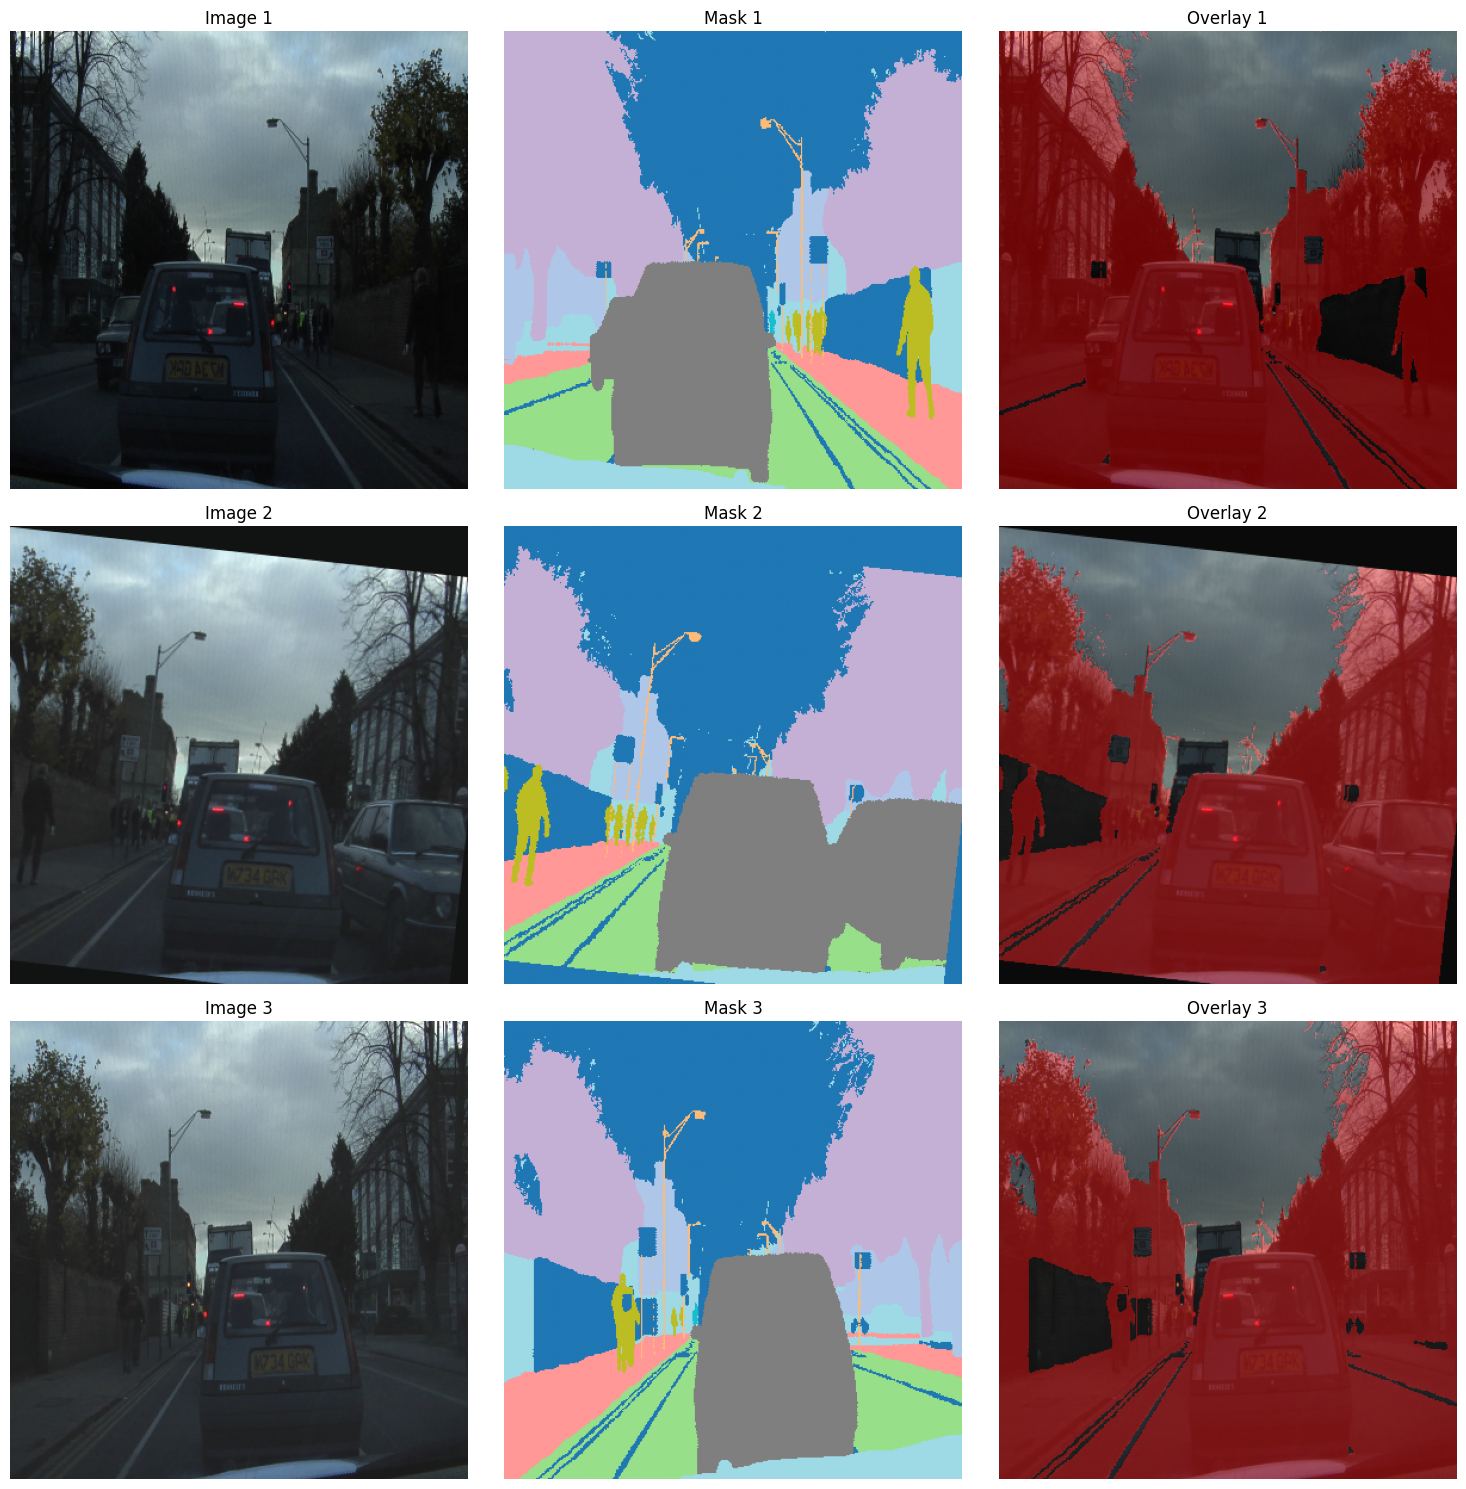

Image shape: torch.Size([3, 384, 384])
Mask shape: torch.Size([384, 384])
Mask unique values: tensor([ 0,  1,  2,  3,  4,  5,  8,  9, 10, 11], dtype=torch.int32)


In [26]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
for i in range(3):
    image, mask = train_dataset[i]  # dataset возвращает кортеж (image, mask)
    
    img_np = image.permute(1, 2, 0).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = img_np * std + mean
    img_np = np.clip(img_np, 0, 1)
    
    mask_np = mask.numpy()
    
    axes[i, 0].imshow(img_np)
    axes[i, 0].set_title(f'Image {i+1}')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(mask_np, cmap='tab20', vmin=0, vmax=11)
    axes[i, 1].set_title(f'Mask {i+1}')
    axes[i, 1].axis('off')
    
    overlay = img_np.copy()
    mask_colored = np.zeros_like(img_np)
    mask_colored[mask_np > 0] = [1, 0, 0]
    overlay = overlay * 0.6 + mask_colored * 0.4
    
    axes[i, 2].imshow(overlay)
    axes[i, 2].set_title(f'Overlay {i+1}')
    axes[i, 2].axis('off')
plt.tight_layout()
plt.show()
print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape}")
print(f"Mask unique values: {torch.unique(mask)}")

## Инициализация модели

Создаём модель UNet и Lightning модуль для обучения.


In [27]:
unet_module = UNetModule(
    model=model,
    learning_rate=2e-4,
    weight_decay=1e-4
)

sample_input = torch.randn(1, 3, 384, 384)
with torch.no_grad():
    sample_output = unet_module(sample_input)

print(f"Input shape: {sample_input.shape}")
print(f"Output shape: {sample_output.shape}")
print(f"Model parameters: {sum(p.numel() for p in unet_module.parameters()):,}")

Input shape: torch.Size([1, 3, 384, 384])
Output shape: torch.Size([1, 12, 384, 384])
Model parameters: 13,160,628


## Обучение модели

Настраиваем callbacks и запускаем обучение с использованием PyTorch Lightning.


In [28]:
import pytorch_lightning as pl
# Добавляем TQDMProgressBar в импорт
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, TQDMProgressBar

# Настройка чекпоинта для сохранения лучшей модели по val_iou
checkpoint_callback = ModelCheckpoint(
    monitor='val_iou',       # Следим за метрикой mIoU на валидации
    dirpath='checkpoints/',  # Папка для сохранения
    filename='best-unet-{val_iou:.3f}',
    save_top_k=1,            # Сохраняем только 1 лучший результат
    mode='max',              # Нам нужно максимальное значение IoU
)

lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval='step')

# Создаем кастомный прогресс-бар
class EpochProgressBar(TQDMProgressBar):
    def on_train_epoch_end(self, trainer, pl_module):
        super().on_train_epoch_end(trainer, pl_module)
        # Печатает пустую строку, чтобы прогресс-бар предыдущей эпохи 
        # не затирался следующим, а оставался в истории
        print(f" Epoch {trainer.current_epoch}: val_iou={trainer.callback_metrics.get('val_iou', 0):.4f}")

trainer = pl.Trainer(
    max_epochs=100,
    accelerator="auto",
    devices=1,
    precision="16-mixed",
    callbacks=[checkpoint_callback, lr_monitor, EpochProgressBar()], # Используем наш класс
    log_every_n_steps=1,
    enable_progress_bar=True
)

Using 16bit Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


In [29]:
# Запуск обучения
module = UNetModule(model, learning_rate=1e-3)
trainer.fit(module, train_loader, val_loader)

C:\Users\seog\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:881: Checkpoint directory C:\Users\seog\Desktop\cv2025-main\lesson3\homework\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
C:\Users\seog\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
C:\Users\seog\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\utilities\model_summary\model_summa

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\seog\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 99: 100%|██████████| 47/47 [01:16<00:00,  0.61it/s, v_num=4, train_loss_step=0.185, train_iou_step=0.715, val_loss=0.251, val_iou=0.653, train_loss_epoch=0.146, train_iou_epoch=0.719]

`Trainer.fit` stopped: `max_epochs=100` reached.


 Epoch 99: val_iou=0.6532
Epoch 99: 100%|██████████| 47/47 [01:16<00:00,  0.61it/s, v_num=4, train_loss_step=0.185, train_iou_step=0.715, val_loss=0.251, val_iou=0.653, train_loss_epoch=0.146, train_iou_epoch=0.719]


Image batch shape: torch.Size([8, 3, 384, 384])
Mask batch shape: torch.Size([8, 384, 384])
Image data range: -2.1179039478302 to 2.6399998664855957
Mask unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=torch.int32)


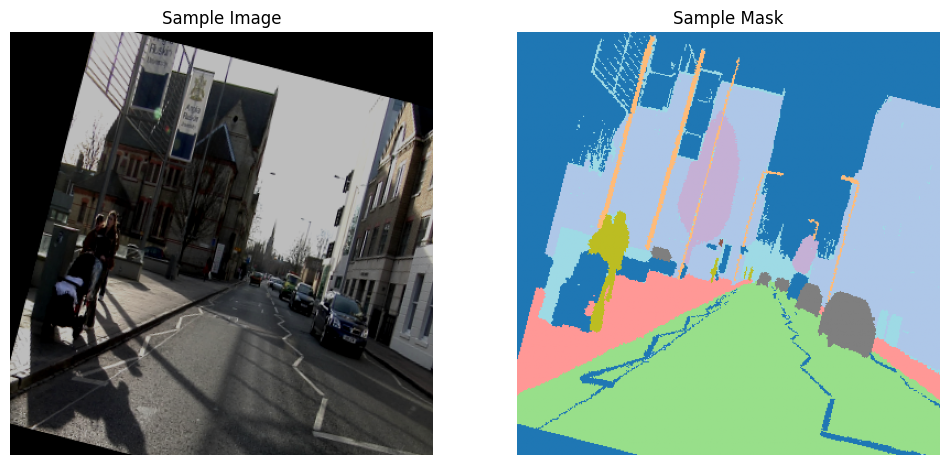

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Получаем один батч данных из train_loader
try:
    # Убедитесь, что train_loader определен и доступен
    batch = next(iter(train_loader))
    # На эти (универсальный способ для вашего baseline):
    if isinstance(batch, dict):
        images, masks = batch['image'], batch['mask']
    else:
        images, masks = batch

    print(f"Image batch shape: {images.shape}")
    print(f"Mask batch shape: {masks.shape}")
    print(f"Image data range: {images.min()} to {images.max()}")
    print(f"Mask unique values: {torch.unique(masks)}")

    # Визуализируем первый пример из батча
    img = images[0].permute(1, 2, 0).numpy()
    mask = masks[0].squeeze().numpy()

    # Денормализация для корректного отображения
    # Эти значения должны соответствовать тем, что использовались в A.Normalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(img)
    ax[0].set_title("Sample Image")
    ax[0].axis('off')

    ax[1].imshow(mask, cmap='tab20', vmin=0, vmax=11) # 12 классов
    ax[1].set_title("Sample Mask")
    ax[1].axis('off')

    plt.show()

except NameError:
    print("Переменная 'train_loader' не найдена. Пожалуйста, убедитесь, что ячейка с его созданием была выполнена.")
except Exception as e:
    print(f"Произошла ошибка: {e}")
